<a href="https://colab.research.google.com/github/AnnaSokolova27/NLP-disaster-tweets-/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk


from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train.sample(10)

,id,keyword,location,text,target
2362,3398,demolition,NaN,7 Christians detained in Zhejiang amid widespr...,0
4674,6644,inundation,Cascadia,@kathrynschulz Plus you're well out of the inu...,0
6698,9595,thunder,??,Oh shit its rly sheeting\nAaaaaand there's the...,1
2395,3446,derail,NaN,Dozens Die As two Trains Derail Into A River I...,1
1663,2400,collapsed,NaN,Petition | Heartless owner that whipped horse ...,1
2199,3152,debris,"labuan, malaysia",Aircraft debris confirmed to be from MH370 - N...,1
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
3771,5354,fire,"Yuba City, CA",When your heart is bigger than the obstacles ...,0
3004,4317,dust%20storm,D(M)V,@RetiredFilth people in sydney woke up to the ...,1
6658,9541,terrorist,Iraq|Afghanistan| RSA |Baghdad,Don't say @ALIPAPER: women got problems this #...,0


Посмотрим, сколько строк в тренировочных данных.

In [ ]:
train.shape

(7613, 5)

Посмотрим, сколько строк в тестовых данных.

In [ ]:
test.shape

(3263, 4)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Посмотрим, как распределена целевая переменная. Как мы можем видеть, дисбаланс есть, но он не слишком большой.

Text(0.5, 1.0, 'Countplot for Disaster and Non-disaster Related Tweets')

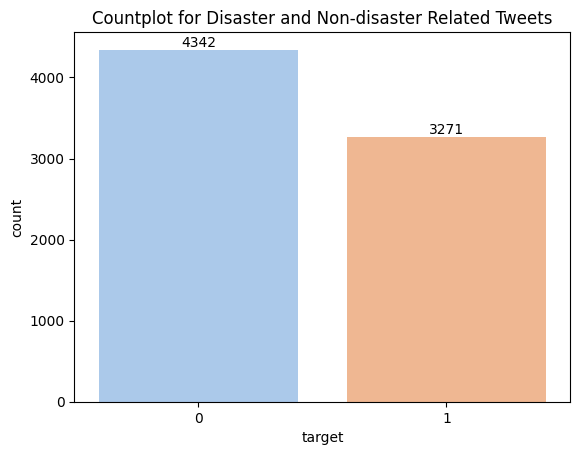

In [ ]:
ax = sns.countplot(data=train, x='target', palette='pastel')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Countplot for Disaster and Non-disaster Related Tweets')

Посмотрим на 20 самых распространённых значений столбца "keyword".

<Axes: xlabel='keyword'>

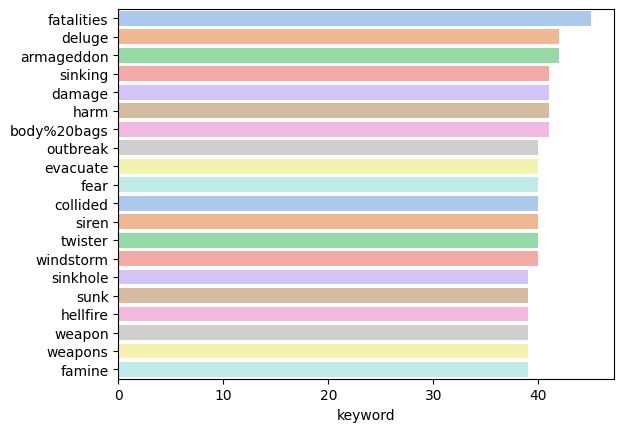

In [ ]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h', palette='pastel')

Посмотрим на 10 самых распространённых значений столбца "location".

<Axes: xlabel='location'>

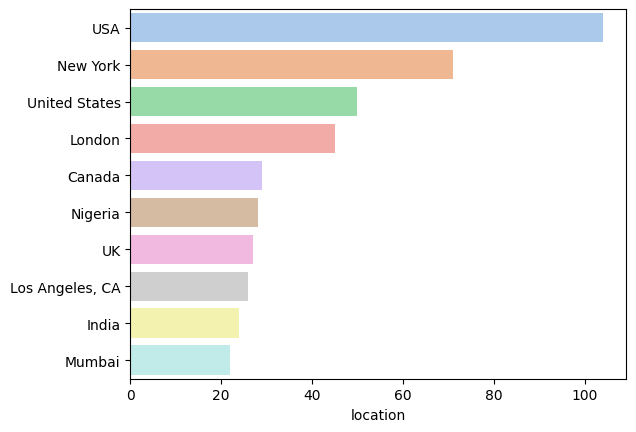

In [ ]:
sns.barplot(y=train['location'].value_counts()[:10].index,x=train['location'].value_counts()[:10],
            orient='h', palette='pastel')

Столбцы id, keyword и location не несут никакой дополнительной информации о том, содержится ли в твите информация о реальном чрезвычайном происшествии, поэтому их можно удалить.

In [ ]:
train.drop(columns=['id','keyword', 'location'], inplace=True)
test.drop(columns=['id','keyword', 'location'], inplace=True)

Проверим, нет ли в данных дубликатов.

In [ ]:
train.duplicated(['text', 'target']).sum()

92

Удалим дубликаты.

In [ ]:
train = train.drop_duplicates(["text", "target"])

Посмотрим на длину твитов датасета.

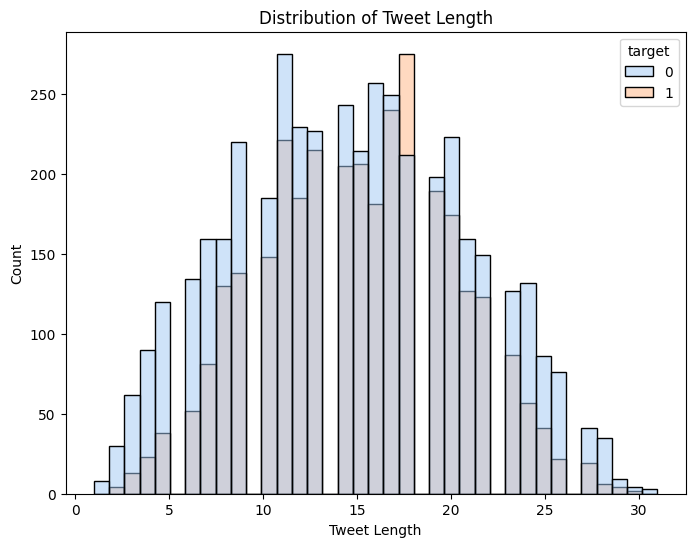

In [ ]:
train['tweet_length'] = train['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(data=train, x='tweet_length', hue='target', palette='pastel')
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

Проведём очистку текста. С помощью регулярных выражений удалим все ненужные символы.

In [ ]:
def clean_text(text):

    text=text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('u^', '', text)
    text = re.sub(r'(&amp;|&gt;|&lt;)', " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ',text)
    text = re.sub(r'@\S{0,}', ' USER ', text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r'\b(USER)( \1\b)+', r'\1', text)
    text = re.sub(r'([a-zA-Z])\1{1,}', r'\1\1', text)
    text = re.sub(r"htt\S{0,}", " ", text)
    text = re.sub(r"[^a-zA-Z\d\s]", " ", text)
    text = re.sub(r'^\d\S{0,}| \d\S{0,}| \d\S{0,}$', ' NUMBER ', text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r'\b(NUMBER)( \1\b)+', r'\1', text)
    text = re.sub(r"[0-9]", " ", text)
    text = text.strip()
    text = re.sub(r' via\s{1,}USER$', ' ', text)
    text = re.sub(r"\s+", " ", text)
    return text

train['text']=train['text'].apply(lambda x :clean_text(x))
test['text']=test['text'].apply(lambda x :clean_text(x))

Разделим текст на токены с помощью tonenizer из библиотеки nltk, который делит текст по заданному с помощью регулярных выражений шаблону. В качестве шаблона возьмём регулярное выражение, которое ловит каждое отдельно написанное слово.

In [ ]:
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
train['text']=train['text'].apply(lambda x : tokenizer.tokenize(x))
test['text']=test['text'].apply(lambda x : tokenizer.tokenize(x))

Удалим слова, не несущие никакой смысловой нагрузки в контексте чрезвычайных происшествий. Изначально словарь таких стоп-слов создавался вручную, однако затем было принято решение воспользоваться готовым словарём библиотеки nltk.

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(tokens):
    tokens = [token for token in tokens if token.lower() not in stopwords]
    return tokens


train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

Приведём каждое слово к его основе, используя стандартные алгоритмы стемминга библиотеки nltk. Изначально стемминг проводился путём ручного отсекания суффиксов и приставок, записанных в отдельный словарь. Однако использование алгоритмов библиотеки, что не удивительно, дало более хороший результат.

In [ ]:
stemmer = nltk.stem.snowball.SnowballStemmer('english')
def stemming(word):
    return stemmer.stem(word)

def preprocess_text(text):
    tokens = [token for token in text]
    stemmed_tokens = [stemming(token) for token in tokens]
    preprocessed_text = ' '.join(stemmed_tokens)
    return preprocessed_text

train['text'] = train['text'].apply(lambda x: preprocess_text(x))
test['text'] = test['text'].apply(lambda x: preprocess_text(x))

В качестве альтернативы было попробовано привести каждое слово к его начальной форме. Для этого также были использованы стандартные функции библиотеки nltk. Однако лемматизация дала более плохой результат, чем стемминг.

In [ ]:
'''
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatization(word):
    return lemmatizer.lemmatize(word)

def preprocess_text(text):
    tokens = [token for token in text]
    lemmatized_tokens = [lemmatization(token) for token in tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

train['text'] = train['text'].apply(lambda x: preprocess_text(x))
test['text'] = test['text'].apply(lambda x: preprocess_text(x))

'''

Перед обучением моделей необходимо перевести слова в числовые векторы.

In [ ]:
vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(train['text'])
vectors2 = vectorizer.transform(test['text'])

Переведём матрицы слов в массивы.

In [ ]:
X = vectors.toarray()
X2 = vectors2.toarray()

Выделим целевой столбец.

In [ ]:
Y = train['target'].values

Разделим тренировочную выборку, чтобы замерить качество модели. Перед загрузкой на Kaggle можно обучить модель на всех данных тренировочной выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Обучим модель LogisticRegression и посмотрим на метрику качества f1_score. Как мы видим, качество получилось не такое уж плохое.

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
f1 = f1_score(y_test, y_pred)
print("f1_score:", f1)

f1_score: 0.7477954144620811


Обучим модель LGBMClassifier и сравним метрики качества f1_score. У этой модели качество получилось чуть хуже.

In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
f1 = f1_score(y_test, y_pred)
print("f1_score:", f1)

f1_score: 0.7016060862214709


Обучим модель CatBoostClassifier и сравним метрики качества f1_score. У этой модели качество получилось примерно такое же, как у модели LGBMClassifier.

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(verbose = False)
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
f1 = f1_score(y_test, y_pred)
print("f1_score:", f1)

f1_score: 0.7032374100719425


Также было попробовано обучить некоторые другие модели, все они давали приблизительно одинаковый результат. Для наглядности оставлены 3 модели, из них лучший результат показала модель LogisticRegression.

Кроме того, было попробовано использовать предобученные модель библиотеки transformers. Решение, какие именно модели использовать, было принято после просмотра раздела с моделями для классификации текстов ресурса paperswithcode. Выбор пал на модели BERT и XLNet, так как они являются одними из самых популярных моделей для решения задач классификации текстов. Однако решение задачи с помощью модели XLNet ещё не было доведено до конца и находится в стадии разработки.
Рассмотрим решение с использованием предобученной модели BERT.

In [ ]:
import os
from datasets import load_dataset, Dataset
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
import torch

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    device = "cpu"

print(device)

cpu


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

Для удобства переведём тренировочный и тестовый датасеты в формат Dataset. Оставим, как и в случае с предыдущими моделями, только столбцы text и target.

In [ ]:
train_dataset = Dataset.from_pandas(train_df[['text', 'target']])
test_dataset = Dataset.from_pandas(test_df[['text']])

Внутри тестового датасета выделим тренировочную и валидационную части. Предварительно перемешаем строки.

In [ ]:
train_dataset = train_dataset.shuffle(seed=42).train_test_split(test_size=0.1, seed=42)

В качестве токенизатора возьмём готовый токенизатор BertTokenizerFast. Токенизатор также автоматически проводит обработку текста и перевод текста в веторное представление.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize(batch):
    text = tokenizer(batch['text'], padding='max_length', max_length=256, truncation=True)
    if 'target' in batch:
        text['labels'] = batch['target']
    return text

In [ ]:
train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=train_dataset['train'].column_names)
test_dataset = test_dataset.map(tokenize, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/6851 [00:00<?, ? examples/s]

Map:   0%|          | 0/762 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [ ]:
train_dataset['train'].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
train_dataset['test'].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Объявим параметры обучения модели.

In [ ]:
training_args = TrainingArguments(
    report_to='none',
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

Загрузим модель.

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

В качестве метрики также возьмём f1_score.

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='binary')
    return {
        'f1': f1
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['test'],
)

Обучим модель.

In [ ]:
history = trainer.train()

Step,Training Loss
10,0.708200
20,0.712400
30,0.681000
40,0.686900
50,0.676100
60,0.652600
70,0.636100
80,0.614200
90,0.585200
100,0.527900


Сделаем предсказания на тестовой выборке и запишем их в csv файл.

In [ ]:
predictions = trainer.predict(test_dataset)
predictions = np.argmax(predictions.predictions, axis=1)

In [ ]:
submission_df['target'] = predictions
submission_df.to_csv('submission.csv', index=False)

f1_score на платформе Kaggle после выгрузки предсказаний данной модели составил 0,83266. Можно сделать вывод, что предобученные модели библиотеки transformers лучше справляются с задачей классификации текстов, чем модели других использованных библиотек.